In [1]:

import time
import sys
print(sys.path)
import json
import traceback
import copy
from scipy import interpolate
from scipy.stats import norm
from nflows.flows.base import Flow
from nflows.utils.torchutils import create_random_binary_mask
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.coupling import *
from nflows.transforms import *
from nflows.nn import nets
from nflows.transforms.coupling import *
from nflows.transforms.autoregressive import *
from nflows.transforms.permutations import ReversePermutation
import traceback
from neural_spline_flows.nde.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from neural_spline_flows.nde.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from neural_spline_flows.nn import ResidualNet
from neural_spline_flows.utils import create_alternating_binary_mask
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from torch import autograd
from torch.autograd import grad
from torch.nn import functional as FF
import numpy as np
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import os
import jetnet 
from jetnet.evaluation import w1p,w1efp,w1m,cov_mmd

import nflows as nf
import matplotlib.pyplot as plt
import mplhep as hep
import hist
from hist import Hist
# import ctypes
from markdown import markdown
#import inspect
from pytorch_lightning.loggers import TensorBoardLogger
from collections import OrderedDict
print("imports ok")
plt.style.use(hep.style.ROOT)
print(torch.cuda.is_available())
from torch.optim.lr_scheduler import CyclicLR,OneCycleLR
from torch import optim
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor
from nflows import flows
from nflows.flows import base
from LitJetNet.LitNF.plotting import plotting
from LitJetNet.LitNF.helpers import *
from LitJetNet.LitNF.jetnet_dataloader import JetNetDataloader



['/gpfs/maxwell/home/kaechben/JetNet_NF', '/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python38.zip', '/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8', '/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/lib-dynload', '', '/home/kaechben/anaconda3/lib/python3.8/site-packages', '/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages']


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


imports ok
True


In [2]:


class LitNF(pl.LightningModule):
    

    def create_resnet(self,in_features, out_features):
        '''This is the network that outputs the parameters of the invertible transformation
        The only arguments can be the in dimension and the out dimenson, the structure
        of the network is defined over the config which is a class attribute
        Context Features: Amount of features used to condition the flow - in our case 
        this is usually the mass
        num_blocks: How many Resnet blocks should be used, one res net block is are 1 input+ 2 layers
        and an additive skip connection from the first to the third'''
        return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=self.config["network_nodes"],
                context_features=1 if config["conditional"] else None,
                num_blocks=self.config["network_layers"],
                activation=self.config["activation"]  if "activation" in self.config.keys() else FF.relu,
                dropout_probability=config["dropout"] if "dropout" in self.config.keys() else 0,
                use_batch_norm=self.config["batchnorm"] if "batchnorm" in self.config.keys() else 0,

                    )
    def __init__(self,config):
        '''This initializes the model and its hyperparameters'''
        super().__init__()
        
        self.config=config
        
        #Metrics to track during the training
        self.metrics={"w1p":[],"w1m":[],"w1efp":[]}
        #Loss function of the Normalizing flows
        self.logprobs=[]
        self.hparams.update(config)
        self.save_hyperparameters()
        #This is the Normalizing flow model to be used later, it uses as many
        #coupling_layers as given in the config 
        self.flows = []
        self.n_dim=self.config["n_dim"]
        K=self.config["coupling_layers"]
        for i in range(K):
            '''This creates the masks for the coupling layers, particle masks are masks
            created such that each feature particle (eta,phi,pt) is masked together or not'''
            if "particle_masks" in self.config.keys() and self.config["particle_masks"] and i==0:
                mask=create_random_binary_mask(self.n_dim//3)            
                mask=mask.repeat_interleave(3)
            else:
                mask=create_random_binary_mask(self.n_dim)
            #Flows can be used as an autoregressive transform, in theory this would be better
            #but this is much slower
            if self.config["autoreg"]:
                self.flows += [MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                    features=self.n_dim,
                    num_blocks=self.config["network_layers"], 
                    hidden_features=self.config["network_nodes"],
                    context_features=1 if config["conditional"] else None,
                    tails='linear',
                    tail_bound=3,
                    num_bins=self.config["bins"],
                    use_residual_blocks=True,
                    use_batch_norm=self.config["batchnorm"],
                    activation=FF.relu
                            )]
            #Something fun to test, this uses a monotonic network which is invertible
            elif self.config["UMNN"]:
                self.flows += [UMNNCouplingTransform(
                    mask=mask,
                    transform_net_create_fn=create_resnet,
                     integrand_net_layers=[300,200],
                    cond_size=20,
                    nb_steps=20,
                    solver="CCParallel",
                    apply_unconditional_transform=False
                )]
            #Just the standard in this study, use coupling layers
            else:
                self.flows += [PiecewiseRationalQuadraticCouplingTransform(
                    mask=mask,
                    transform_net_create_fn=self.create_resnet, 
                    tails='linear',
                    tail_bound=self.config["tail_bound"],
                    num_bins=self.config["bins"],
                            )]
        #This sets the distribution in the latent space on which we want to morph onto        
        self.q0 = nf.distributions.normal.StandardNormal([self.n_dim])
        #Creates working flow model from the list of layer modules
        self.flows=CompositeTransform(self.flows)
        # Construct flow model
        self.flow = base.Flow(distribution=self.q0, transform=self.flows)


    def load_datamodule(self,data_module):
        '''needed for lightning training to work'''
        self.data_module=data_module
        
    def build_discriminator(self,wgan=False):
        '''this builds a discriminator that can be used to distinguish generated from real
        data, optimally we would want it to have a 50% accuracy, meaning it can distinguish
        This is just a Feed Forward Neural Network
        The wgan keyword makes it a Wasserstein type of discriminator/critic'''
        net=[]
        net.append(nn.Linear(self.n_dim,256))
        for i in range(2):
            net.append(nn.LeakyReLU())
            net.append(nn.Linear(256,256))
        net.append(nn.Linear(256,1))
        if not wgan:
            net.append(nn.Sigmoid())
        self.disc=nn.Sequential(*net)
    
    def compute_gradient_penalty(self, real_samples, fake_samples):
        """This is only need for WGAN trainign Calculates the gradient penalty loss for WGAN GP"""
        # Random weight term for interpolation between real and fake samples
        alpha = torch.Tensor(np.random.random((real_samples.size(0), 1))).to(self.device)
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        interpolates = interpolates.to(self.device)
        d_interpolates = self.disc(interpolates)
        fake = torch.Tensor(real_samples.shape[0], 1).fill_(1.0).to(self.device)
        # Get gradient w.r.t. interpolates
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1).to(self.device)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty
    
    
    def sampleandscale(self,batch,c=None):
        '''This is a helper function that samples from the flow (i.e. generates a new sample) 
            and reverses the standard scaling that is done in the preprocessing. This allows to calculate the mass
            on the generative sample and to compare to the simulated one''' 
            
        if  self.config["conditional"]:
            x= batch[:,:self.n_dim].to(self.device),
            c= batch[:,self.n_dim].reshape(-1,1).to(self.device) if c==None else c
        else: 
            x=batch[:,:self.n_dim].to(self.device)
            c=None
        #This make sure that everything is on the right device
        self.data_module.scaler.to(self.device)
        self.flow.to(self.device)
        #Not here that this sample is conditioned on the mass of the current batch allowing the MSE 
        #to be calculated later on
        gen=self.flow.sample(1,c.reshape(-1,1)).reshape(-1,self.n_dim).to(self.device)
        gen=self.data_module.scaler.inverse_transform(torch.hstack((gen[:,:self.n_dim]
            .reshape(-1,self.n_dim),torch.ones(len(gen)).to(self.device).unsqueeze(1))))
        true=self.data_module.scaler.inverse_transform(batch.to(self.device)).to(self.device)
        m=true[:,self.n_dim]
        m_g=mass(gen[:,:self.n_dim].to(self.device) ,
                 self.config["canonical"]).to(self.device) 
        return gen,true,m,m_g
    
    def configure_optimizers(self):
        self.batch_size=self.config["batch_size"]
        #learning rate
        self.lr=self.config["lr"]
        #Total Loss (can be a sum of multiple terms)
        self.losses=[]
        #mlosses are initialized with None during the time it is not turned on, makes it easier to plot
        self.mlosses=[None for i in range(min(self.config["n_mse_delay"],self.config["max_steps"]))]
        self.n_dim=self.config["n_dim"]  
        lr = self.lr
        opt_g = torch.optim.Adam(self.flow.parameters(), lr=lr)
        
        if self.config["disc"]:
            n_critic = 1 #this sets how many critic iterations per one generator iteration
            opt_d = torch.optim.Adam(self.disc.parameters(), lr=lr)
            return (
            {'optimizer': opt_g, 'frequency': 1},
            {'optimizer': opt_d, 'frequency': n_critic}
        )
        else:
            return (
            {'optimizer': opt_g, 'frequency': 1},
        )
    def w_loss(self,gen,true):
        #Wasserstein loss that can be used for gan like training 8which doesnt make a lot of sense)
        lambda_gp=10
        real_validity = self.disc(true[:,:self.n_dim])
                # Fake images
        fake_validity = self.disc(gen[:,:self.n_dim])
        gradient_penalty = self.compute_gradient_penalty(true[:,:self.n_dim], gen[:,:self.n_dim])
        return  -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
    
    def bce(self,true,gen): 
        #calculates binary cross entropy, used to train discriminator
        real=self.disc(true[:,:self.n_dim]).reshape(-1,1)
        fake=self.disc(gen[:,:self.n_dim]).reshape(-1,1)
        bc=torch.nn.BCELoss()
        loss=bc(real,torch.ones_like(real))
        loss+=bc(fake,torch.zeros_like(real))
        return  loss
    
    def training_step(self, batch, batch_idx,optimizer_idx=0,wgan=False):
        if  self.config["conditional"]:
            x, c = batch[:,:self.n_dim],batch[:,self.n_dim].reshape(-1,1)
        else: 
            x=batch[:,:self.n_dim]
            c=None
        if self.config["calc_massloss"]:   
            gen,true,m,m_g=self.sampleandscale(batch)   
            #the mass loss is an interesting metric, if we dont add it to the generator loss it will not influence the training
            mloss=self.config["lambda"]*FF.mse_loss(m_g.to(self.device).reshape(-1),m.to(self.device).reshape(-1))

        if optimizer_idx == 0:
            g_loss = -self.flow.log_prob(x,c).mean()/self.n_dim #This is the classic Normalizing Flow loss
            self.log("logprob", g_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True) 
#                 self.logprobs.append(g_loss.detach().cpu().numpy())                
            if  self.global_step>self.config["n_mse_delay"] and self.global_step<self.config["n_mse_turnoff"]:
                g_loss+=mloss
            self.log("mass_loss", mloss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            self.losses.append(g_loss.detach().cpu().numpy())
            self.mlosses.append(mloss.detach().cpu().numpy())
            return OrderedDict({"loss":g_loss})
        # train discriminator, if config["disc"]= False, this wont be used
        if optimizer_idx == 1:
            if wgan:
                d_loss=self.w_loss()
            else:
                d_loss=self.bce(true,gen)
                yhat=torch.round(model.disc(batch[:,:self.n_dim]))
                TP=yhat.sum()/len(yhat)
                TN=torch.round(torch.ones_like(yhat)-model.disc(gen[:,:self.n_dim])).sum()/len(yhat)
            if self.config["disc"]:
                self.log("d_loss", d_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
                self.log("TP",TP,on_step=False, on_epoch=True, prog_bar=True, logger=True  ) 
                self.log("TN",TN,on_step=False, on_epoch=True, prog_bar=True, logger=True  ) 
                self.log("AC",(TP+TN)/2,on_step=False, on_epoch=True, prog_bar=True, logger=True  ) 
            return OrderedDict({"loss":d_loss})

    def validation_step(self, batch, batch_idx):
        '''This calculates some important metrics on the hold out set'''
        self.data_module.scaler.to("cpu")        
        with torch.no_grad():
            if self.config["conditional"]:
                gen=self.flow.to("cpu").sample(1,batch[:,self.n_dim].reshape(-1,1).to("cpu")).to("cpu")
                gen=self.data_module.scaler.inverse_transform(torch.hstack((gen[:,:self.n_dim].cpu().detach()
                    .reshape(-1,self.n_dim),torch.ones(len(gen)).unsqueeze(1))))
            else:
                gen=self.flow.sample(len(batch)).to("cpu")
                gen=self.data_module.scaler.inverse_transform(torch.hstack((gen[:,:self.n_dim]
                    .cpu().detach().reshape(-1,self.n_dim),torch.ones(len(gen)).unsqueeze(1))))
        true=self.data_module.scaler.inverse_transform(batch.cpu())
        m_t=true[:,self.n_dim].to(self.device)
        m_gen=mass(gen[:,:self.n_dim],self.config["canonical"])
        self.metrics["w1p"].append(w1p(gen[:,:self.n_dim].reshape(-1,self.n_dim//3,3).numpy(),true[:,:self.n_dim].reshape(-1,self.n_dim//3,3)))
        self.metrics["w1m"].append(w1m(gen[:,:self.n_dim].reshape(-1,self.n_dim//3,3).numpy(),true[:,:self.n_dim].reshape(-1,self.n_dim//3,3)))
        self.metrics["w1efp"].append(w1efp(gen[:,:self.n_dim].reshape(-1,self.n_dim//3,3).numpy(),true[:,:self.n_dim].reshape(-1,self.n_dim//3,3)))
        self.metrics["w1efp"].append(0)    
        self.log("val_w1m",self.metrics["w1m"][-1][0],on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_w1p",self.metrics["w1p"][-1][0],on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.plot=plotting(model=self,gen=gen,true=true,config=config,step=self.global_step,logger=self.logger.experiment)
        if self.config["disc"]:
            with torch.no_grad():
                    self.plot.plot_scores(self.disc(true[:,:self.n_dim].to(self.device)).cpu().numpy(),self.disc(gen[:,:self.n_dim].to(self.device)).cpu().numpy(),save=True)
        try:
            self.plot.plot_mass(m_gen.cpu().numpy(),m_t.cpu().numpy(),save=True,quantile=True)
#             self.plot.plot_marginals(save=True)
            self.plot.plot_2d(save=True)
            self.plot.losses(save=True)
        except Exception as e:
            traceback.print_exc()
# #         self.flow.to("cuda")


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.datasets import make_moons
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
config={
        "network_layers":2,
        "network_nodes":128,
        "batch_size":2000,
        "coupling_layers":15,#tune.uniform(3,20),#tune.randint(6,300),
        "conditional":True,
        "lr":0.0001,
        "batchnorm":False,
        "autoreg":False,
        "bins":8,
        "UMNN":False,
        "tail_bound":10,
        "n_mse_delay":10,
        "limit":100000,
        "n_dim":90,
        "dropout":0.0,
        "lr_schedule":False,
        "gamma":0.75,
        "n_sched":1000,
        "canonical":False,
        "max_steps":100000,
        "lambda":500,
        "n_mse_turnoff":1000,
        "name":"debug",
        "disc":False,
        "activation":FF.leaky_relu,
        "particle_masks":True,
        "calc_massloss":True
        }

data_module = JetNetDataloader(config)
model=LitNF(config=config)
logger= TensorBoardLogger("lightning_logs", name=config["name"],log_graph=False)
checkpoint_callbacks = [
                        ModelCheckpoint(monitor="val_w1m",filename="best_mass-{}".format(config["n_dim"])),
                         ModelCheckpoint(monitor="val_w1p",filename="best_logprob-{}".format(config["n_dim"]))
,pl.callbacks.StochasticWeightAveraging(75)]
    #EarlyStopping(monitor="val_w1m", mode="min",min_delta=0.0001,patience=5)]
path="lightning_logs/debug/version_16/checkpoints/"
#path="LitJetNet/best_model/checkpoints/"

ckpt=os.listdir(path)[0]
# model.build_discriminator()
model=LitNF.load_from_checkpoint(path+ckpt)
model.load_datamodule(data_module)
model.config=config

model.lr=config["lr"]
trainer = pl.Trainer(gpus=1,log_every_n_steps=10,#auto_scale_batch_size="binsearch",
                     auto_lr_find=False,max_epochs=1000,callbacks=checkpoint_callbacks,
                     gradient_clip_val=0.5, gradient_clip_algorithm="value",check_val_every_n_epoch=10  
                    ,fast_dev_run=False,logger=logger,stochastic_weight_avg=False)
# # # trainer.tune(model,data_module)
# # # lr_finder = trainer.tuner.lr_find(model,data_module, early_stop_threshold=100, min_lr=1e-5)
trainer.fit(model,train_dataloaders=data_module, ckpt_path=checkpoint_callbacks[0].best_model_path)
# # # # print("hello")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | q0    | StandardNormal     | 0     
1 | flows | CompositeTransform | 6.2 M 
2 | flow  | Flow               | 6.2 M 
---------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.731    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0:   0%|                                                                                 | 0/1 [00:00<?, ?it/s]

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9:  98%|███████████████████████████████████▏| 45/46 [05:04<00:06,  6.76s/it, loss=0.019, v_num=19, logprob=0.011, mass_loss=0.00554]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|█| 46/46 [05:19<00:00,  6.94s/it, loss=0.019, v_num=19, logprob=0.011, mass_loss=0.00554, val_w1m=0.000568, val_w1p=0.00195]
Epoch 19:  98%|▉| 45/46 [10:18<00:13, 13.74s/it, loss=0.00463, v_num=19, logprob=0.00156, mass_loss=0.00539, val_w1m=0.000568, val_w1p=0.0
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]
Epoch 19: 100%|█| 46/46 [10:32<00:00, 13.76s/it, loss=0.00463, v_num=19, logprob=0.00156, mass_loss=0.00539, val_w1m=0.000566, val_w1p=0.0
Epoch 29:  98%|▉| 45/46 [15:12<00:20, 20.28s/it, loss=-0.00601, v_num=19, logprob=-.00583, mass_loss=0.00603, val_w1m=0.000566, val_w1p=0.
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                           

In [4]:
print(model.state_dict
     )

<bound method Module.state_dict of LitNF(
  (q0): StandardNormal()
  (flows): CompositeTransform(
    (_transforms): ModuleList(
      (0): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=46, out_features=128, bias=True)
          (blocks): ModuleList(
            (0): ResidualBlock(
              (context_layer): Linear(in_features=1, out_features=128, bias=True)
              (linear_layers): ModuleList(
                (0): Linear(in_features=128, out_features=128, bias=True)
                (1): Linear(in_features=128, out_features=128, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (1): ResidualBlock(
              (context_layer): Linear(in_features=1, out_features=128, bias=True)
              (linear_layers): ModuleList(
                (0): Linear(in_features=128, out_features=128, bias=True)
                (1): Linear(in_features=128, 

In [ ]:
data_module = JetNetDataloader(config)
data_module.setup(stage=None)
model.data_module=data_module
plt.figure(figsize=(10,10))
plt.hist(m.detach().cpu().numpy()-m_g.detach().cpu().numpy(),bins=30)
plt.title("Mass Resolution")
textstr = '\n'.join((
    r'$\sigma_{sim}\cdot 10^{3}=%.1f$' % (m.detach().cpu().std().numpy()*1e3, ),
    r'$\sigma_{\Delta}\cdot 10^{3}=%.1f$' % ((m-m_g).detach().cpu().std().numpy()*1e3, ),
    r'$ (\bar{m}_{sim}-\bar{m}_{gen} )\cdot 10^{3}=%.1f$' % ((m-m_g).detach().cpu().mean().numpy()*1e3, )))

plt.text(-0.021,10**2.7,textstr,fontsize=20)
plt.xlabel("$m_{sim}-m_{gen}$")
plt.ylabel("Count")
plt.yscale("log")
plt.xlim(-0.023,0.023)
plt.show()

/tmp/ipykernel_15495/3401510344.py:4: UserWarning: Attempting to set identical left == right == 0.1286572962999344 results in singular transformations; automatically expanding.
  plt.xlim(m_grid[0],m_grid[-1])


(array([1.200e+01, 1.021e+03, 7.690e+03, 1.268e+03, 8.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.10861158, 0.1162338 , 0.12385602, 0.13147825, 0.13910046,
        0.14672269, 0.15434492, 0.16196714, 0.16958937, 0.17721158,
        0.18483381], dtype=float32),
 <BarContainer object of 10 artists>)

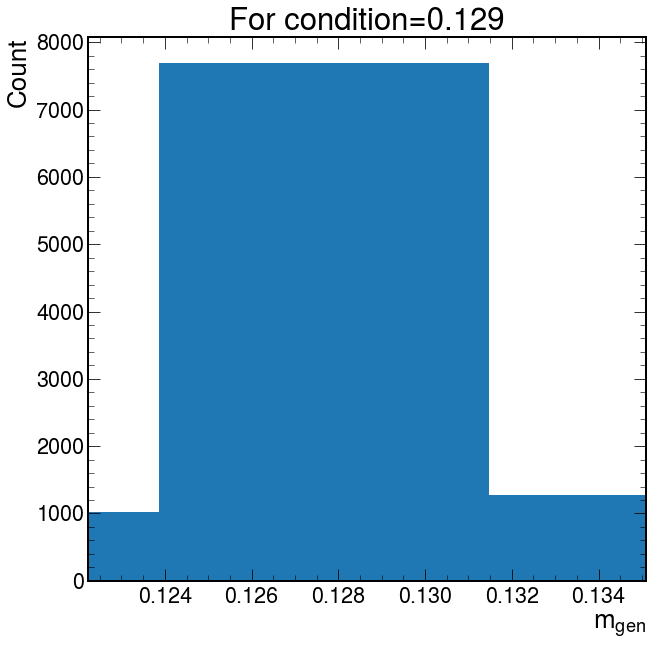

In [182]:
plt.title("For condition=%.3f"%m_grid[i])
plt.xlabel("$m_{gen}$")
plt.ylabel("Count")
plt.xlim(m_grid[0],m_grid[-1])
true=data_module.test_set[:10000,:]
true[:,-1]=torch.ones(10000)*m_grid[0]
c=model.data_module.scaler.transform(true)[:,-1]
_,_,m,m_g=model.sampleandscale(true,c)
plt.hist(m_g.detach().cpu().numpy())

<Figure size 720x720 with 0 Axes>

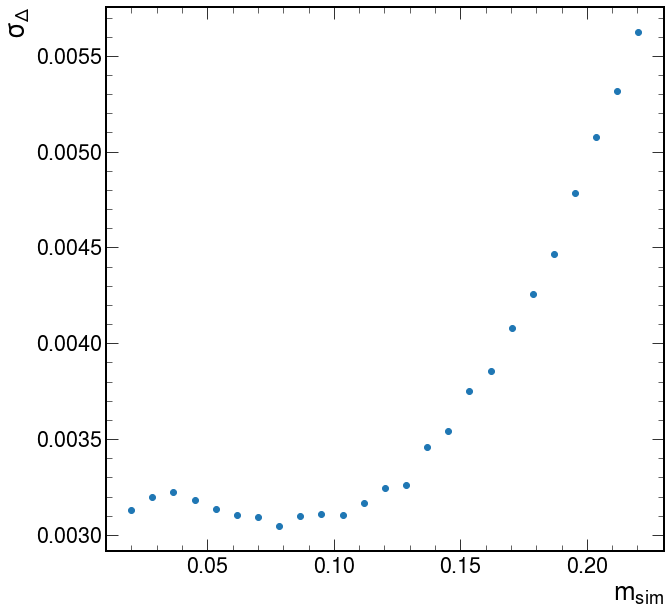

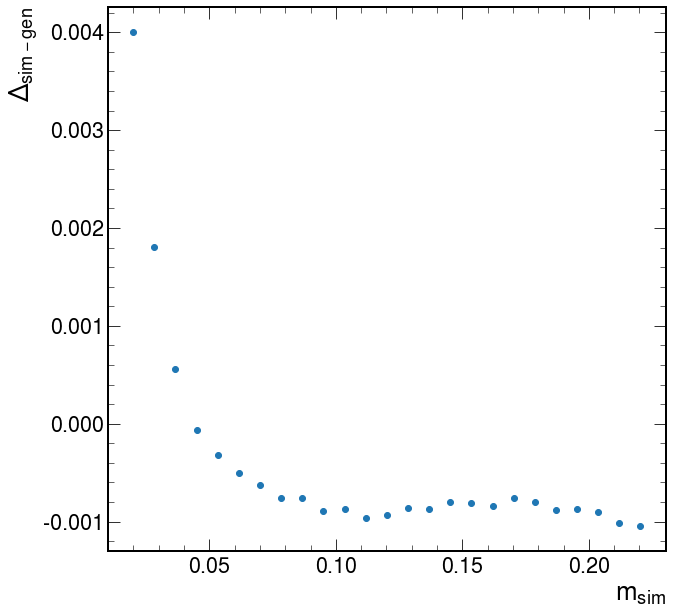

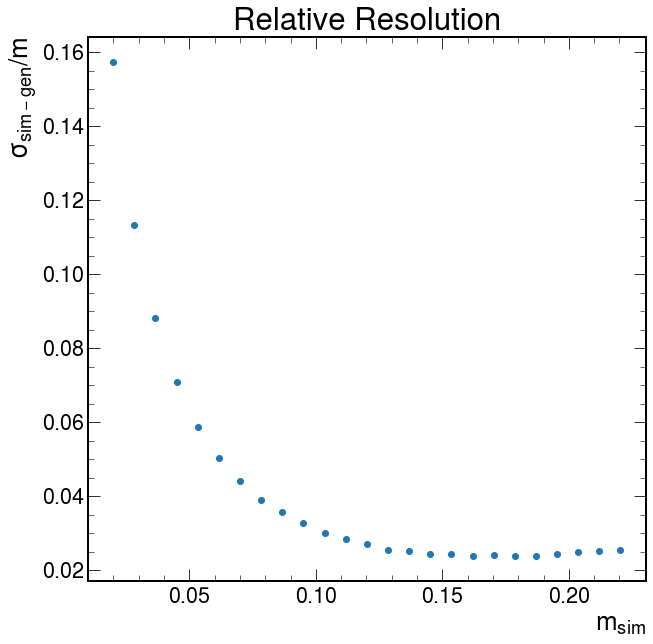

Text(0, 1, '$\\Delta_{sim-gen}/m$')

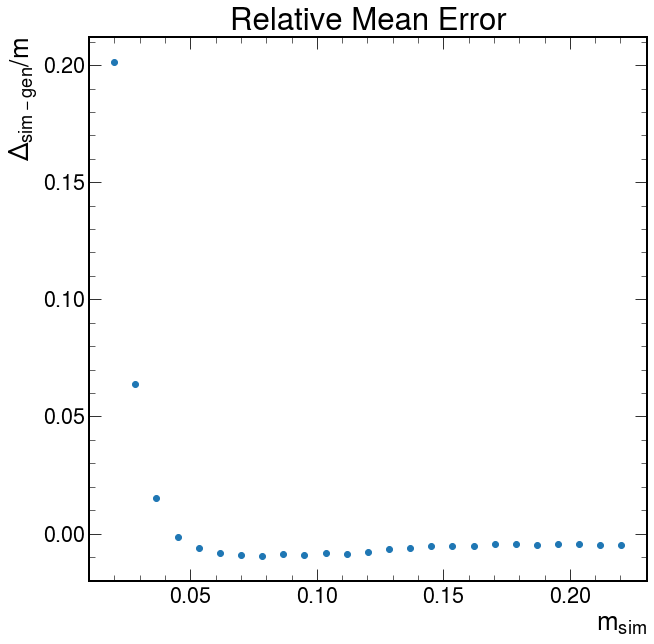

In [189]:
# def plot_resolution(m,m_g,ax):

#     ax.hist(m-m_g.detach().cpu().numpy(),bins=30)
# #     plt.title("Mass Resolution")
# #     textstr = '\n'.join((
# #         r'$\sigma_{sim}\cdot 10^{3}=%.1f$' % (m.detach().cpu().std().numpy()*1e3, ),
# #         r'$\sigma_{\Delta}\cdot 10^{3}=%.1f$' % ((m-m_g).detach().cpu().std().numpy()*1e3, ),
# #         r'$ (\bar{m}_{sim}-\bar{m}_{gen} )\cdot 10^{3}=%.1f$' % ((m-m_g).detach().cpu().mean().numpy()*1e3, )))

# #     plt.text(-0.021,10**2.7,textstr,fontsize=20)
#     ax.set_xlabel("$m_{sim}-m_{gen}$")
#     ax.set_ylabel("Count")
#     ax.set_yscale("log")
#     ax.set_xlim(-0.3,0.3)  
#     ax.set_title("Condition m=%.3f"%m)
# _,_,m,m_g=model.sampleandscale(data_module.test_set[:10000,:],c=None)
# fig,axes=plt.subplots(nrows=5,ncols=5,figsize=(25,25))
# m_grid=np.linspace(m.min().detach().cpu().numpy(),m.max().detach().cpu().numpy(),25)
# print(m_grid)
# std=[]
# means=[]
# for i in range(25):
#     true=data_module.test_set[:10000,:]
#     true[:,-1]=torch.ones(10000)*m_grid[i]
#     c=model.data_module.scaler.to(model.device).transform(true.to(model.device))[:,-1]
#     _,_,m,m_g=model.sampleandscale(data_module.test_set[:10000,:],c=c)
#     plot_resolution(m_grid[i],m_g,axes[i//5,i%5])
#     means.append(np.mean(m_g.detach().cpu().numpy()-m_grid[i]))
#     std.append(np.std(m_g.detach().cpu().numpy()-m_grid[i]))
plt.tight_layout()
plt.show()
plt.plot(m_grid,std,"o")
plt.xlabel("$m_{sim}$")
plt.ylabel("$\sigma_{\Delta}$")
plt.show()
plt.plot(m_grid,means,"o")
plt.xlabel("$m_{sim}$")
plt.ylabel("$\Delta_{sim-gen}$")    
plt.show()

plt.title("Relative Resolution")
plt.plot(m_grid,np.array(std)/m_grid,"o")
plt.xlabel("$m_{sim}$")
plt.ylabel("$\sigma_{sim-gen}/m$")
plt.show()
plt.title("Relative Mean Error")
plt.plot(m_grid,means/m_grid,"o")
plt.xlabel("$m_{sim}$")
plt.ylabel("$\Delta_{sim-gen}/m$")           

In [164]:
m_grid

array([0.12528001, 0.12528001, 0.12528001, 0.12528001, 0.12528001,
       0.12528001, 0.12528001, 0.12528001, 0.12528001, 0.12528001,
       0.12528001, 0.12528001, 0.12528001, 0.12528001, 0.12528001,
       0.12528001, 0.12528001, 0.12528001, 0.12528001, 0.12528001,
       0.12528001, 0.12528001, 0.12528001, 0.12528001, 0.12528001])

In [ ]:
fig,ax=plt.subplots(nrows=6,ncols=5)
with torch.no_grad():
    gen=model.flow.sample(1,model.data_module.test_set[:1000,-1].reshape(-1,1).to(model.device)).reshape(-1,model.n_dim).to(model.device)
    gen=model.data_module.scaler.to(model.device).inverse_transform(torch.hstack((gen[:,:model.n_dim]
        .reshape(-1,model.n_dim),torch.ones(len(gen)).to(model.device).unsqueeze(1))))
    m_g=mass(gen[:,:model.n_dim].to(model.device) ,
             model.config["canonical"]).to(model.device) 
    true=model.data_module.scaler.inverse_transform(model.data_module.test_set[:1000].to(model.device)).to(model.device)

for i in range(model.n_dim//3):
    print(i)
    
    ax[i//5,i%5].hist(gen[:,i].cpu().numpy(),alpha=.5)
    ax[i//5,i%5].hist(true[:,i].cpu().numpy(),alpha=.5)
plt.show()

In [ ]:
def weights_update(model, checkpoint):
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

model = weights_update(model=LitNF(config), checkpoint=torch.load(path+ckpt))
model

LitNF()

In [34]:

gen=model.flow.to("cpu").sample(1,model.data_module.test_set[:,model.n_dim].reshape(-1,1).to("cpu")).to("cpu")
model.data_module.scaler.to("cpu")
gen=model.data_module.scaler.inverse_transform(torch.hstack((gen[:,:model.n_dim].cpu().detach()
    .reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))))

In [40]:
w1m(gen[:,:-1].reshape(-1,30,3).numpy(),data_module.scaler.inverse_transform(
    data_module.test_set)[:,:-1].numpy().reshape(-1,30,3))

(0.0015678800973296166, 0.0003996104565015741)

/tmp/ipykernel_34693/3612226001.py:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


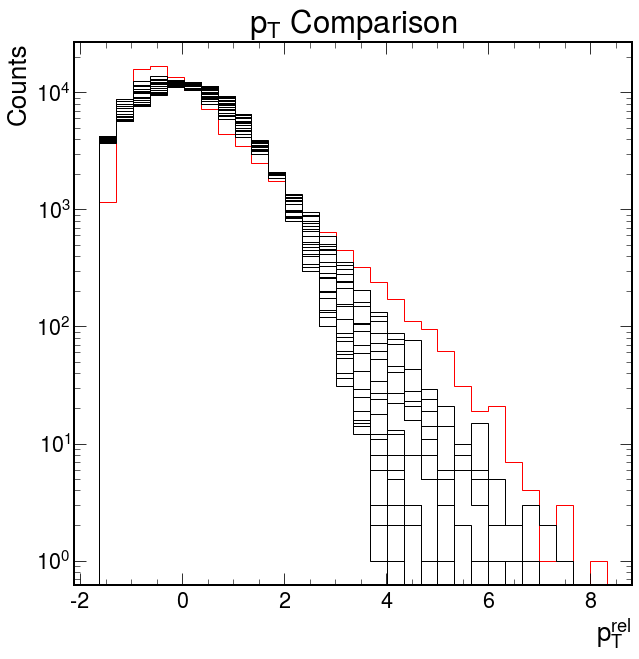

In [25]:
_,b,_=plt.hist(model.data_module.data[:,2].numpy(),bins=30,alpha=1,edgecolor='red',fill=None,histtype='stepfilled')
for i in range(1,model.data_module.data.shape[1]//3):
    
    plt.hist(model.data_module.data[:,2+3*i].numpy(),bins=b,alpha=1,color='red',fill=None,histtype='stepfilled')
plt.title("$p_T$ Comparison")
plt.ylabel("Counts")
plt.xlabel("$p_T^{rel}$")
plt.yscale('log')
plt.show()

In [73]:
# gc.collect()
del model
torch.cuda.empty_cache()

In [209]:
model=LitNF(config)
best_model=model.load_from_checkpoint(checkpoint_callback.best_model_path)
